# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
    
train.csv  
test.csv


### Задание:
    
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:  
Price

#### Метрика качества:

R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Требования к решению:
**1**. R2 > 0.6  
**2**. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb  
**3**. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv   
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

### Рекомендации для файла с кодом (ipynb):  
**1**. Файл должен содержать заголовки и комментарии (markdown)  
**2**. Повторяющиеся операции лучше оформлять в виде функций  
**3**. Не делать вывод большого количества строк таблиц (5-10 достаточно)  
**4**. По возможности добавлять графики, описывающие данные (около 3-5)  
**5**. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта  
**6**. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)  
**7**. Весь проект должен быть в одном скрипте (файл ipynb).  
**8**. Допускается применение библиотек Python и моделей машинного обучения,  
которые были в данном курсе.  

#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = 'c:/data1/train.csv'
TEST_DATASET_PATH = 'c:/data1/test.csv'

## Загрузка данных

### Описание датасета:
**Id**  -  идентификационный номер квартиры  
**DistrictId** - идентификационный номер района  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь  
**KitchenSquare** - площадь кухни  
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности  
**Social_1**, **Social_2**, **Social_3** - социальные показатели местности  
**Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры  

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Memory use optimization

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
def fix_id_DistrictId(df):
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    return df

In [8]:
train = fix_id_DistrictId(train)

In [9]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


In [10]:
train.dtypes

Id               category
DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### Проверка данных

In [11]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [12]:
train.shape

(10000, 20)

### Обзор данных

#### Целевая переменная

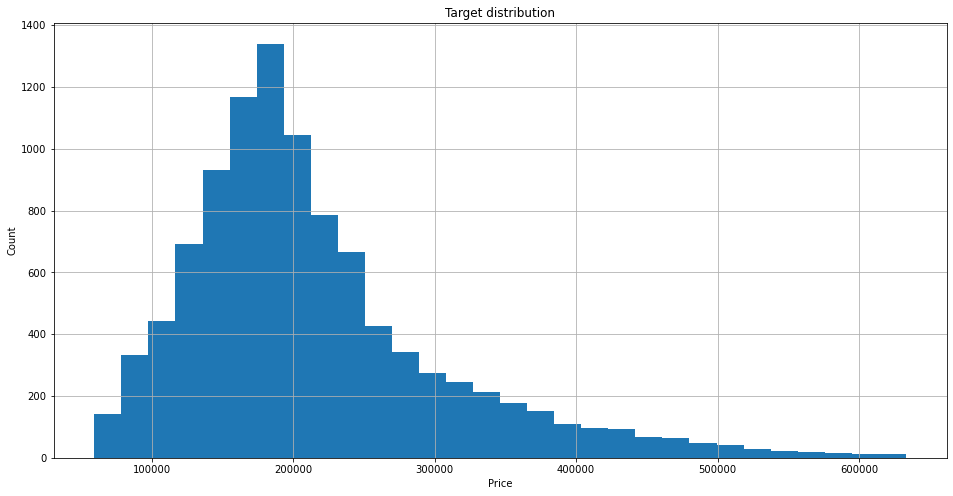

In [13]:
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')


plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [14]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [15]:
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### Категориальные переменные

In [16]:
cat_colnames = train.select_dtypes(include='category').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



In [18]:
df_num_features = train.select_dtypes(include=['int8', 'float32', 'int32', 'int16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [19]:
df_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


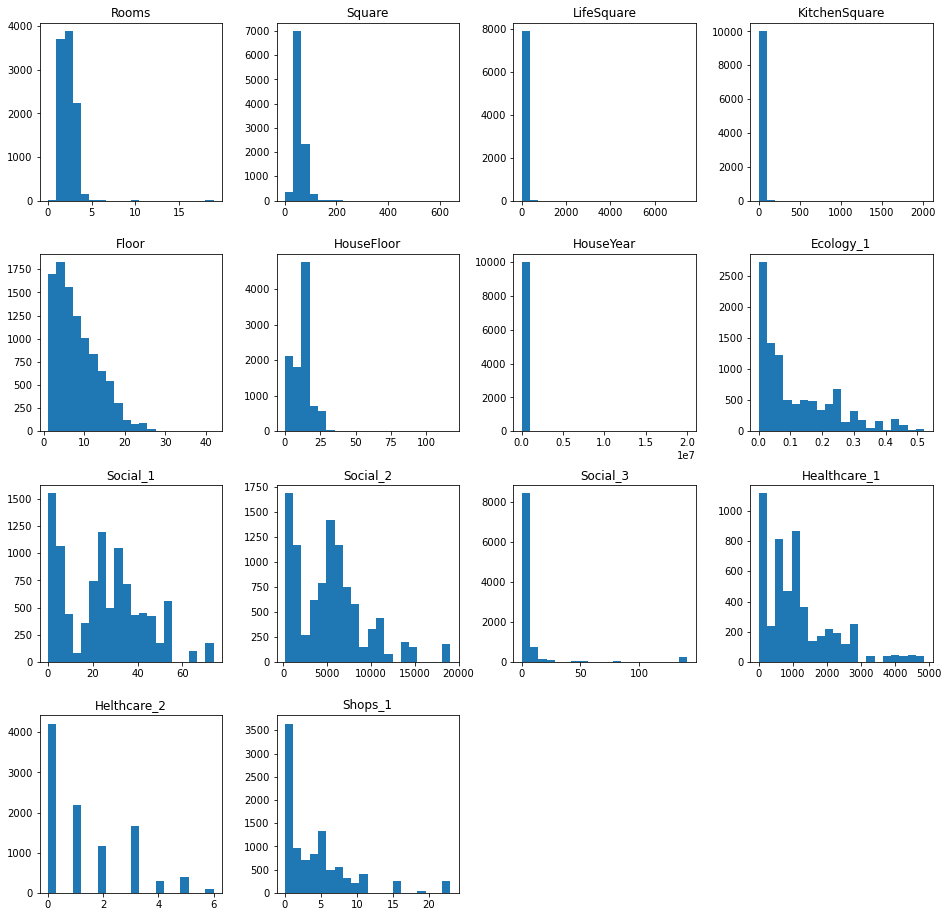

In [20]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

### Обработка выбросов

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

#### Rooms

In [22]:
train.loc[(train['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
1981,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
2269,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
4366,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
8834,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875


In [23]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [24]:
def df_fix_room(df):
    df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 5), 'Rooms'] = int(df['Rooms'].median())
    return df

In [25]:
train = df_fix_room(train)

In [26]:
train['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

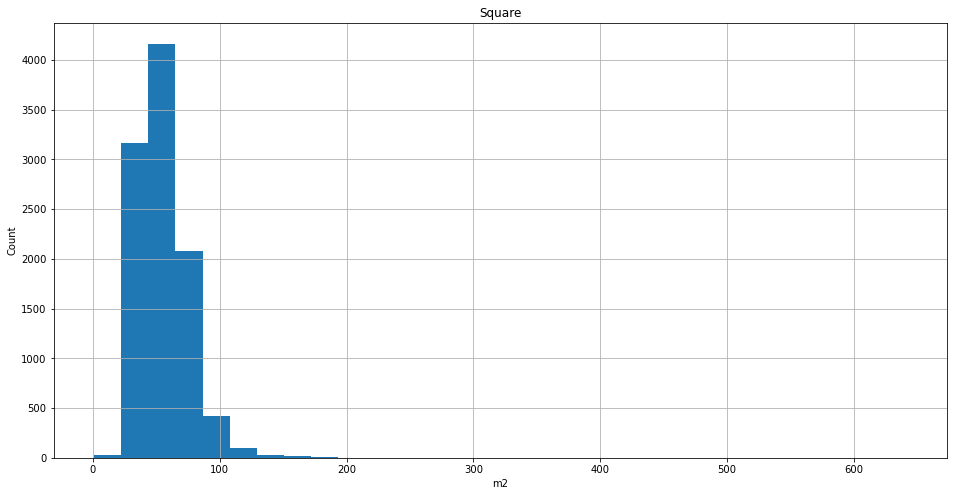

In [27]:
plt.figure(figsize = (16, 8))

train['Square'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('m2')

plt.title('Square')
plt.show()

In [28]:
def Fix_Square(df):
    df.loc[(df['Square'] < 20) & (df['Square'] > 300), 'Square'] = df['Square'].median()
    return df

In [29]:
train = Fix_Square(train)

In [30]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.811071,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,5.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### LifeSquare

In [31]:
def Fix_LifeSquare(df):
    df.loc[df['LifeSquare'] > 250, 'LifeSquare'] = df['Square'] - df['KitchenSquare']
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] - df['KitchenSquare']
    
    return df

In [32]:
train = Fix_LifeSquare(train)

In [33]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.315712,40.996304,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.811071,21.058718,22.310843,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,25.494156,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,37.040831,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,49.813482,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,5.000000,641.065186,631.065186,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### KitchenSquare

In [34]:
def Fix_KitchenSquare(df):
    df.loc[(df['KitchenSquare'] > 5) & (df['KitchenSquare'] > 20), 'KitchenSquare'] = df['KitchenSquare'].median()
    df.loc[(df['KitchenSquare'] > df['Square']), 'KitchenSquare'] = df['KitchenSquare'].median()
    return df

In [35]:
train = Fix_KitchenSquare(train)

#### Healthcare_1

In [36]:
def fix_Healthcare_1(df):
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    return df

In [37]:
train = fix_Healthcare_1(train)

#### HouseFloor, Floor

In [38]:
def fix_HouseFloor_Floor(df):
    df.loc[(df['HouseFloor']>48), 'HouseFloor'] = int(df['HouseFloor'].mean())
    df.loc[(df['Floor'] > df['HouseFloor']), 'Floor'] = int(df['Floor'].mean())
    df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloor'] = int(df['HouseFloor'].mean())
    return df

In [39]:
train = fix_HouseFloor_Floor(train)

#### HouseYear

In [40]:
train.loc[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250
4189,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375


Text(0.5, 1.0, 'Distribution of variable House Year')

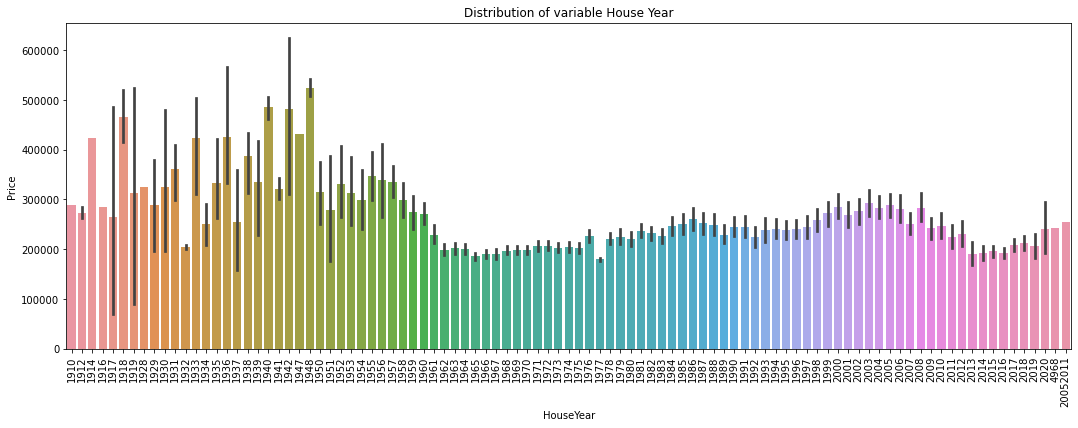

In [41]:
plt.figure(figsize=(18, 6))
sns.barplot(train['HouseYear'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

In [42]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [43]:
train = df_fix_house_year_manual(train)

### Построение новых признаков

#### Ecology

In [44]:
 def fix_Ecology(df):
    df['Ecology_2'] = df['Ecology_2'].map({'A': 0, 'B': 1})
    df['Ecology_3'] = df['Ecology_3'].map({'A': 0, 'B': 1})
    df['Shops_2'] = df['Shops_2'].map({'A': 0, 'B': 1})
    return df

In [45]:
train = fix_Ecology(train)

##### Средняя стоимость м2 по району:

In [46]:
#def fix_SquareMeterPrice(df):
    #df["SquareMeterPrice"] = df["Price"] / df["Square"]
    #return df

In [47]:
#train = fix_SquareMeterPrice(train)
train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531250
5,12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,1,1,35,7715,4,990.0,0,6,1,215898.453125
6,14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,1,1,20,4386,14,900.0,1,5,1,296021.218750
7,11993,74,2.0,80.312927,80.312927,0.0,8,12.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,221244.156250
8,5172,1,2.0,64.511436,63.511436,1.0,9,17.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,229102.796875
9,8649,23,1.0,46.461411,18.915552,8.0,13,17.0,2014,0.075779,1,1,6,1437,3,900.0,0,2,1,95380.218750


##### Средняя площадь одной комнаты:

In [48]:
def fix_RoomSquare(df):
    df['RoomSquare'] = df['LifeSquare'] / df['Rooms']
    return df

In [49]:
train = fix_RoomSquare(train)
train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,RoomSquare
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,900.0,0,11,1,184966.937500,14.721375
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,240.0,1,16,1,300009.437500,13.349847
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,1,34,7759,0,229.0,1,3,1,220925.906250,14.598805
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,1084.0,0,5,1,175616.234375,26.365755
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2078.0,2,4,1,150226.531250,23.776169
5,12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,...,1,35,7715,4,990.0,0,6,1,215898.453125,15.561240
6,14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,...,1,20,4386,14,900.0,1,5,1,296021.218750,18.580189
7,11993,74,2.0,80.312927,80.312927,0.0,8,12.0,1977,0.075779,...,1,6,1437,3,900.0,0,2,1,221244.156250,40.156464
8,5172,1,2.0,64.511436,63.511436,1.0,9,17.0,1977,0.007122,...,1,1,264,0,900.0,0,1,1,229102.796875,31.755718
9,8649,23,1.0,46.461411,18.915552,8.0,13,17.0,2014,0.075779,...,1,6,1437,3,900.0,0,2,1,95380.218750,18.915552


### Modelling

#### Load packages

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Function

In [51]:
def data_prepare(df):
    df = fix_id_DistrictId(df)
    df = reduce_mem_usage(df)
    df = df_fix_room(df)
    df = Fix_Square(df)
    df = Fix_LifeSquare(df)
    df = Fix_KitchenSquare(df)
    df = fix_Healthcare_1(df)
    df = fix_HouseFloor_Floor(df)
    df = df_fix_house_year_manual(df)
    df = fix_Ecology(df)
    #df = fix_SquareMeterPrice(df)
    df = fix_RoomSquare(df)
    return df

In [52]:
test = data_prepare(test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.39 MB
Decreased by 46.4%


In [53]:
train.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
RoomSquare       0
dtype: int64

### Разбиение на train и test

In [54]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Helthcare_2', 'Shops_2', 'RoomSquare']


target_name = 'Price'

In [55]:
train = train[feature_names + [target_name]]
test = test[feature_names + ['Id']]
X = train[feature_names]
y = train[target_name]

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

## Random Forest Regressor

In [58]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=11, random_state=21, max_features=7)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=7, n_estimators=1000,
                      random_state=21)

Train R2:	0.877
Test R2:	0.722


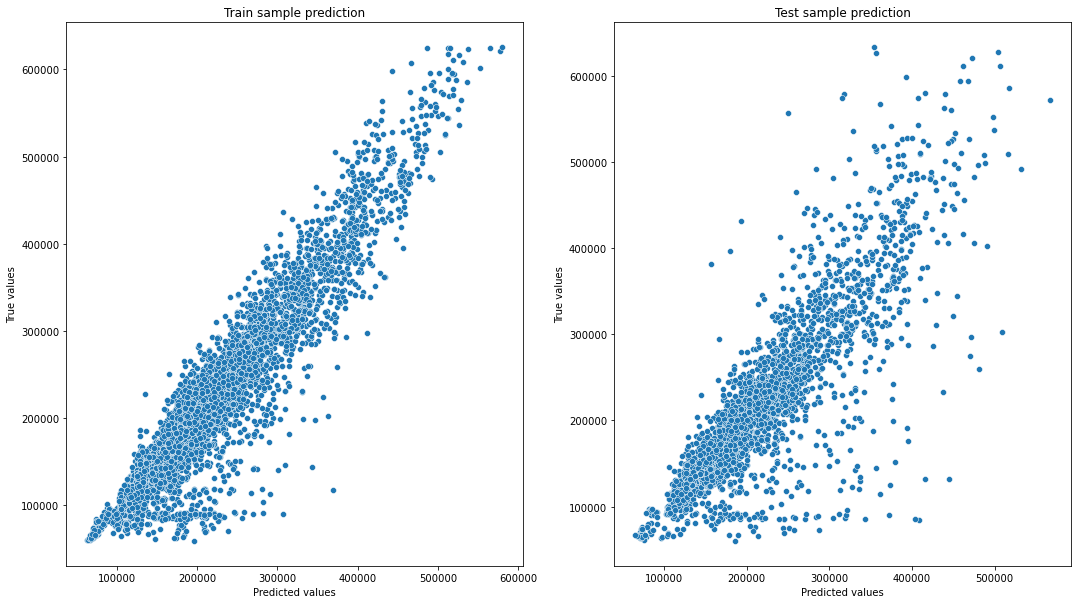

In [59]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## Формирование файла с прогнозами

In [60]:
preds_final = pd.DataFrame()
preds_final['Id'] = test['Id'].copy()

test.set_index('Id', inplace=True)
test = test[feature_names]

In [61]:
predictions = rf_model.predict(test)



In [66]:
y_pred_final = rf_model.predict(test)



preds_final['Price'] = y_pred_final
preds_final.to_csv('c:/data/DEshtokin_predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,168761.851566
1,15856,186952.486436
2,5480,209843.305121
3,15664,339533.665144
4,14275,130429.442025
